In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm                   # To get certain color maps for plotting
from matplotlib.colors import to_hex
import scipy
import itertools
from nltk import wordpunct_tokenize, WordNetLemmatizer, pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
from textblob import TextBlob, Word
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')
pd.set_option('display.width', 500)
pd.set_option('max_columns', 60)

In [ ]:
reviews=pd.read_csv('yelp/restaurants_reviews_clean.csv', index_col=0)

In [4]:
reviews.head(3)

,business_id,cool,date,funny,review_id,stars_x,text,useful,user_id,address,Alcohol,Ambience casual,Ambience classy,Ambience divey,Ambience hipster,Ambience intimate,Ambience romantic,Ambience touristy,Ambience trendy,Ambience upscale,BikeParking,BusinessAcceptsCreditCards,BusinessParking garage,BusinessParking lot,BusinessParking street,BusinessParking valet,BusinessParking validated,Caters,DogsAllowed,GoodForKids,...,HasTV,NoiseLevel,OutdoorSeating,RestaurantsAttire,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,WheelchairAccessible,WiFi,categories,city,hours Friday,hours Monday,hours Saturday,hours Sunday,hours Thursday,hours Tuesday,hours Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars_y,state
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,False,loud,False,casual,False,True,2,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1.0,45.5164,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953.0,4.0,QC
1,0W4lkclzZThpx3V65bVgig,0,2011-09-28,0,FunI9om-aK5oMIIJmhMlZA,4,a must stop when you are in montreal!\r\n\r\nI...,0,u0LXt3Uea_GidxRW1xcsfg,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,False,loud,False,casual,False,True,2,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1.0,45.5164,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953.0,4.0,QC
2,0W4lkclzZThpx3V65bVgig,2,2016-02-22,1,ufI413zxZqGwIBIInnM5Rg,4,*Schwartz's has become a Montreal's famous lan...,4,xYciRtVZ1PW4IxSX4oJ1aw,3895 Boulevard Saint-Laurent,none,True,False,NaN,False,False,False,False,False,False,True,False,False,False,True,False,False,True,NaN,True,...,False,loud,False,casual,False,True,2,False,True,True,True,no,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,8:00-1:30,8:00-0:30,8:00-2:30,8:00-0:30,8:00-0:30,8:00-0:30,8:00-0:30,1.0,45.5164,-73.577537,Schwartz's,Plateau-Mont-Royal,H2W 1X9,1953.0,4.0,QC


In [5]:
reviews.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars_x', 'text', 'useful', 'user_id', 'address', 'Alcohol', 'Ambience casual', 'Ambience classy', 'Ambience divey', 'Ambience hipster', 'Ambience intimate', 'Ambience romantic', 'Ambience touristy', 'Ambience trendy', 'Ambience upscale', 'BikeParking', 'BusinessAcceptsCreditCards', 'BusinessParking garage', 'BusinessParking lot', 'BusinessParking street', 'BusinessParking valet', 'BusinessParking validated', 'Caters', 'DogsAllowed',
       'GoodForKids', 'GoodForMeal breakfast', 'GoodForMeal brunch', 'GoodForMeal dessert', 'GoodForMeal dinner', 'GoodForMeal latenight', 'GoodForMeal lunch', 'HasTV', 'NoiseLevel', 'OutdoorSeating', 'RestaurantsAttire', 'RestaurantsDelivery', 'RestaurantsGoodForGroups', 'RestaurantsPriceRange2', 'RestaurantsReservations', 'RestaurantsTableService', 'RestaurantsTakeOut', 'WheelchairAccessible', 'WiFi', 'categories', 'city', 'hours Friday', 'hours Monday', 'hours Saturday', 'hours Sunday',
      

In [6]:
# For topic clustering we don't need some of the columns, just keep a few
columns_to_keep=['date', 'stars_x', 'text', 'categories', 'city', 'latitude', 'longitude', 'name', 'review_count', 'state']
reviews_for_clustering=reviews[columns_to_keep]

In [7]:
reviews_for_clustering.to_csv('yelp/reviews_for_clustering.csv')

In [3]:
reviews=pd.read_csv('yelp/reviews_for_clustering.csv', index_col=0)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
reviews.head(2)

,date,stars_x,text,categories,city,latitude,longitude,name,review_count,state,Cuisine
0,2016-05-28,5,"Love the staff, love the meat, love the place....","['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,45.516373,-73.577537,Schwartz's,1953,QC,Delis Ethnic Food Imported Restaurants Sandwic...
1,2011-09-28,4,a must stop when you are in montreal!\r\r\r\n\...,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,45.516373,-73.577537,Schwartz's,1953,QC,Delis Ethnic Food Imported Restaurants Sandwic...


In [4]:
reviews.drop_duplicates(inplace=True)

In [5]:
reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3540098 entries, 0 to 3540133
Data columns (total 10 columns):
date            3540098 non-null object
stars_x         3540098 non-null object
text            3540098 non-null object
categories      3540097 non-null object
city            3540097 non-null object
latitude        3540097 non-null object
longitude       3540096 non-null float64
name            3540096 non-null object
review_count    3540096 non-null float64
state           3540096 non-null object
dtypes: float64(2), object(8)
memory usage: 297.1+ MB


In [6]:
# Just a few null entries. Drop those rows
reviews.dropna(inplace=True)

In [7]:
reviews.reset_index(drop=True, inplace=True)

In [8]:
reviews.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540096 entries, 0 to 3540095
Data columns (total 10 columns):
date            3540096 non-null object
stars_x         3540096 non-null object
text            3540096 non-null object
categories      3540096 non-null object
city            3540096 non-null object
latitude        3540096 non-null object
longitude       3540096 non-null float64
name            3540096 non-null object
review_count    3540096 non-null float64
state           3540096 non-null object
dtypes: float64(2), object(8)
memory usage: 270.1+ MB


In [9]:
# Convert stars_x and review_count to integer and latitude to float
reviews['stars_x']=reviews['stars_x'].astype(int)
reviews['review_count']=reviews['review_count'].astype(int)
reviews['latitude']=reviews['latitude'].astype(float)

In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540096 entries, 0 to 3540095
Data columns (total 10 columns):
date            object
stars_x         int32
text            object
categories      object
city            object
latitude        float64
longitude       float64
name            object
review_count    int32
state           object
dtypes: float64(2), int32(2), object(6)
memory usage: 243.1+ MB


To use categories for further analysis (e.g. after clustering to see for each cuisine what are the common topics), I will convert them into easier to manipulate strings.

In [11]:
categories=[re.findall('\w+', x) for x in reviews['categories']]

In [12]:
categories=[list(set(x)) for x in categories]

In [13]:
categories=[sorted(x) for x in categories]

In [14]:
categories[0]

['Delis',
 'Ethnic',
 'Food',
 'Imported',
 'Restaurants',
 'Sandwiches',
 'Specialty']

In [15]:
categories=[' '.join(x) for x in categories]

In [16]:
reviews['Cuisine']=categories

In [19]:
reviews['Cuisine'].value_counts()[0:5]

Mexican Restaurants                100907
Chinese Restaurants                 55636
Pizza Restaurants                   51420
Bars Japanese Restaurants Sushi     49216
Italian Restaurants                 47702
Name: Cuisine, dtype: int64

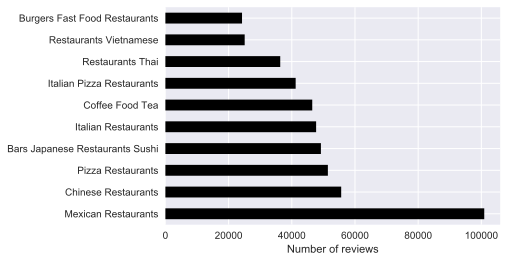

In [25]:
# Plot top 10 cuisines in these reviews
reviews['Cuisine'].value_counts()[0:10].plot(kind='barh', color='k')
plt.xlabel('Number of reviews')
plt.show()

In [23]:
reviews.to_csv('yelp/reviews_for_clustering.csv')

In [35]:
reviews=pd.read_csv('yelp/reviews_for_clustering.csv', index_col=0)

d:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [36]:
reviews.head(3)

,date,stars_x,text,categories,city,latitude,longitude,name,review_count,state,Cuisine
0,2016-05-28,5,"Love the staff, love the meat, love the place....","['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,45.516373,-73.577537,Schwartz's,1953,QC,Delis Ethnic Food Imported Restaurants Sandwic...
1,2011-09-28,4,a must stop when you are in montreal!\r\r\r\n\...,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,45.516373,-73.577537,Schwartz's,1953,QC,Delis Ethnic Food Imported Restaurants Sandwic...
2,2016-02-22,4,*Schwartz's has become a Montreal's famous lan...,"['Specialty Food', 'Sandwiches', 'Restaurants'...",Montréal,45.516373,-73.577537,Schwartz's,1953,QC,Delis Ethnic Food Imported Restaurants Sandwic...


In [5]:
# To start finding topic, I will use the text column and try stemming and lemmatization to see if the clustering will be 
# different using these two methods
# Make a function to lemmatize
def lemma(sent):
    lemmatizer=WordNetLemmatizer()
    tokens=[]
    # Get all lemmas for verbs, adjectives, adverbs and nouns
    for word, tag in pos_tag(wordpunct_tokenize(sent)):
        if word not in stop_words and word.isalpha():
            if tag.startswith('NN'):
                word=lemmatizer.lemmatize(word, 'n')
            elif tag.startswith('JJ'):
                word=lemmatizer.lemmatize(word, 'a')
            elif tag.startswith('VB'):
                word=lemmatizer.lemmatize(word, 'v')
            elif tag.startswith('RB'):
                word=lemmatizer.lemmatize(word, 'r')
            tokens.append(word)
    return(tokens)

In [53]:
# Make a function to stem words
def stem(sent):
    stemmer=SnowballStemmer("english")
    tokens=[]
    for word in wordpunct_tokenize(sent):
        if word.isalpha():
            word=stemmer.stem(word)
        tokens.append(word)
    return(tokens)

In [59]:
# First tokenize and then lemmatize or stem. Define a function to use in tfidf vectorizer
def tfidf_tokenizer_stem(text):
    tokens=[word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    stemmer=SnowballStemmer("english")
    no_punct_tokens=[]
    for token in tokens:
        if token.isalpha():
            no_punct_tokens.append(token)
    stems = [stemmer.stem(t) for t in no_punct_tokens]
    return(tokens)

def tfidf_tokenizer_lemma(text):
    tokens=[]
    sents=sent_tokenize(text)
    tokens=[tokens.extend(lemma(sent.lower)) for sent in sents]
    return(tokens)

In [8]:
# First tokenize and then stem. Define a function
def tokenizer(text):
     # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    sentences = [sent_tokenize(t.lower()) for t in text]
    tokens=[]
    for sentence_list in sentences:
        for sentence in sentence_list:        
            token=wordpunct_tokenize(sentence)
            tokens.extend(token)
    tokens=[x for x in tokens if x not in stop_words and x.isalpha() ]
    return(tokens)

To create a 1:1 relationship between stemmed words to the original words, we can use the tokenizer function to create a data frame using original tokens as index and stemmed as columns

In [2]:
stop_words=set(stopwords.words('english'))

I am only interested in restaurants with 4 or 5 star ratings (these are the good restaurants) so I will extract reviews from those first

In [3]:
good_reviews=reviews[(reviews['stars_x']==4) | (reviews['stars_x']==5)]

NameError: name 'reviews' is not defined

In [6]:
len(good_reviews)

2317523

In [3]:
stemmer=SnowballStemmer("english")

In [ ]:
# Construct a stemmed words to original words mapping to interpret our features later on
unique_tokens=[]
for i in range(10):
    sample=good_reviews.iloc[i*240000:(i+1)*240000, :]
    tokens=tokenizer(sample.text)
    stems=[stemmer.stem(x) for x in tokens]
    vocab=pd.DataFrame({'word': tokens}, index=stems)
    vocab.drop_duplicates(inplace=True)
    unique_tokens.append(vocab)

In [26]:
all_vocab=pd.concat(unique_tokens)

In [27]:
len(all_vocab)

1076566

In [28]:
all_vocab.drop_duplicates(inplace=True)

In [29]:
len(all_vocab)

387185

In [30]:
all_vocab.to_csv('yelp/stem_token.csv')

In [4]:
all_vocab=pd.read_csv('yelp/stem_token.csv', index_col=0)

In [5]:
all_vocab.head()

,word
love,love
staff,staff
meat,meat
place,place
prepar,prepare


In [6]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and token.isalpha():
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [7]:
# Define another function to only take certain parts of speech such as noun, adjective etc.
def tokenize_pos_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token) and token.isalpha():
            filtered_tokens.append(token)
    pos_tokens=[]
    for word, tag in pos_tag(filtered_tokens):
        if tag.startswith('NN') or tag.startswith('JJ') or tag.startswith('VB') or tag.startswith('RB'):
            pos_tokens.append(word)
    stems = [stemmer.stem(t) for t in pos_tokens]
    return(stems)

In [33]:
# Instantiate TfidfVectorizer
tfidf=TfidfVectorizer(max_df=0.8, min_df=100, use_idf=True, tokenizer=tokenize_and_stem, stop_words='english',max_features=10000)

In [34]:
tfidf_pos=TfidfVectorizer(max_df=0.8, min_df=100, use_idf=True, tokenizer=tokenize_pos_stem, stop_words='english',
                          max_features=10000)

In [38]:
%time tfidf_matrix=tfidf.fit_transform(good_reviews.text)

Wall time: 2h 34min 11s


In [39]:
# New model using unigrams and keep 10000 features
joblib.dump(tfidf, 'tfidf_stem_vectorizer.pkl')
joblib.dump(tfidf_matrix, 'tfidf_stem_matrix.pkl')

['tfidf_stem_matrix.pkl']

In [40]:
%time tfidf_pos_matrix=tfidf_pos.fit_transform(good_reviews.text)

Wall time: 6h 24min 53s


In [41]:
# New model with pos
joblib.dump(tfidf_pos, 'tfidf_pos.pkl')
joblib.dump(tfidf_pos_matrix, 'tfidf_pos_matrix.pkl')

['tfidf_pos_matrix.pkl']

In [9]:
tfidf_matrix.shape

(2317523, 10000)

In [13]:
tfidf_pos_matrix.shape

(2317523, 10000)

In [8]:
tfidf=joblib.load('tfidf_stem_vectorizer.pkl')
tfidf_matrix=joblib.load('tfidf_stem_matrix.pkl')

In [9]:
tfidf_pos=joblib.load('tfidf_pos.pkl')
tfidf_pos_matrix=joblib.load('tfidf_pos_matrix.pkl')

In [10]:
all_terms=tfidf.get_feature_names()
all_terms_pos=tfidf_pos.get_feature_names()

In [11]:
all_terms[0:10]

['aaa',
 'aaron',
 'ab',
 'aback',
 'abalon',
 'abandon',
 'abbi',
 'abc',
 'abend',
 'aber']

In [12]:
all_terms_pos[0:10]

['aaa',
 'aaron',
 'ab',
 'aback',
 'abalon',
 'abandon',
 'abc',
 'abend',
 'aber',
 'abil']

In [18]:
# First try KMeans to cluster the comments/reviews
km=KMeans(n_clusters=5) #, n_jobs=-5)

In [19]:
# Kmeans on new tfidf matrix with pos
%time km.fit(tfidf_matrix)

Wall time: 9h 18min 28s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
joblib.dump(km, 'kmeans_stem.pkl')

['kmeans_stem.pkl']

In [7]:
km_pos=KMeans(n_clusters=5)

In [8]:
# Kmeans on new tfidf matrix with pos
%time km_pos.fit(tfidf_pos_matrix)

Wall time: 8h 37min 45s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [9]:
# New kmeans algorithm using just unigrams
joblib.dump(km_pos, 'kmeans_pos.pkl')

['kmeans_pos.pkl']

In [13]:
km=joblib.load('kmeans_stem.pkl')

In [14]:
# New model with pos
km_pos=joblib.load('kmeans_pos.pkl')

In [15]:
clusters=km.labels_.tolist()
clusters_pos=km_pos.labels_.tolist()

In [16]:
centers=km.cluster_centers_
centers_pos=km.cluster_centers_

In [14]:
centers.shape

(5, 10000)

In [17]:
centers_terms=pd.DataFrame({'Center 1': centers[0, :], 'Center 2': centers[1, :], 'Center 3': centers[2, :], 
                            'Center 4': centers[3, :], 'Center 5': centers[4, :]}, index=all_terms)

In [18]:
centers_pos_terms=pd.DataFrame({'Center 1': centers_pos[0, :], 'Center 2': centers_pos[1, :], 'Center 3': centers_pos[2, :], 
                                'Center 4': centers_pos[3, :], 'Center 5': centers_pos[4, :]}, index=all_terms_pos)

In [19]:
centers_terms.head()

,Center 1,Center 2,Center 3,Center 4,Center 5
aaa,0.000045,0.000025,0.000017,0.000042,0.000110
aaron,0.000068,0.000131,0.000047,0.000111,0.000083
ab,0.000025,0.000021,0.000017,0.000135,0.000052
aback,0.000072,0.000010,0.000029,0.000033,0.000019
abalon,0.000061,0.000002,0.000000,0.000016,0.000001


In [20]:
centers_pos_terms.head()

,Center 1,Center 2,Center 3,Center 4,Center 5
aaa,0.000045,0.000025,0.000017,0.000042,0.000110
aaron,0.000068,0.000131,0.000047,0.000111,0.000083
ab,0.000025,0.000021,0.000017,0.000135,0.000052
aback,0.000072,0.000010,0.000029,0.000033,0.000019
abalon,0.000061,0.000002,0.000000,0.000016,0.000001


In [36]:
# To print top 10 words associate with each center for stemming method
for i in range(5):
    center=centers_terms.iloc[:, i]
    sorted_center=center.sort_values(ascending=False).index.tolist()[0:10]
    print('Top 10 words associated with cluster ', str(i+1), ' are:')
    print()
    print(sorted_center)
    print('-'*90)

Top 10 words associated with cluster  1  are:

['good', 'order', 'veri', 'food', 'chicken', 'place', 'like', 'realli', 'time', 'tri']
------------------------------------------------------------------------------------------
Top 10 words associated with cluster  2  are:

['great', 'food', 'servic', 'place', 'good', 'veri', 'friend', 'alway', 'love', 'staff']
------------------------------------------------------------------------------------------
Top 10 words associated with cluster  3  are:

['pizza', 'crust', 'good', 'great', 'place', 'order', 'best', 'love', 'veri', 'slice']
------------------------------------------------------------------------------------------
Top 10 words associated with cluster  4  are:

['place', 'love', 'best', 'good', 'food', 'great', 'coffe', 'time', 'like', 'tri']
------------------------------------------------------------------------------------------
Top 10 words associated with cluster  5  are:

['burger', 'fri', 'good', 'great', 'place', 'order', 'f

From above print out, we can manually assign labels to the clusters<br><br>
<b>Cluster 1: Good chicken food</b><br>
<b>Cluster 2: Great service, good staff</b><br>
<b>Cluster 3: Great pizza place</b><br>
<b>Cluster 4: Best coffee shop</b><br>
<b>Cluster 5: Good cheese burger</b><br>

In [38]:
# To print top 10 words associate with each center for stemming and pos method
for i in range(5):
    center=centers_pos_terms.iloc[:, i]
    sorted_center=center.sort_values(ascending=False).index.tolist()[0:10]
    print('Top 10 words associated with cluster ', str(i+1), ' are:')
    print()
    print(sorted_center)
    print('-'*110)

Top 10 words associated with cluster  1  are:

['goddess', 'option', 'verdict', 'foil', 'chicharon', 'pizzeria', 'libr', 'realist', 'til', 'trend']
--------------------------------------------------------------------------------------------------------------
Top 10 words associated with cluster  2  are:

['grassi', 'foil', 'seri', 'pizzeria', 'goddess', 'verdict', 'freshen', 'alyssa', 'lorsqu', 'stabl']
--------------------------------------------------------------------------------------------------------------
Top 10 words associated with cluster  3  are:

['pitt', 'crouton', 'goddess', 'grassi', 'pizzeria', 'option', 'bestellen', 'lorsqu', 'verdict', 'sleev']
--------------------------------------------------------------------------------------------------------------
Top 10 words associated with cluster  4  are:

['pizzeria', 'lorsqu', 'bestellen', 'goddess', 'foil', 'grassi', 'cocoa', 'til', 'libr', 'trend']
-------------------------------------------------------------------------

However, the pos/stem method did not produce much useful info. All the clusters have similar words so pos tagging is not suitable here.

In [39]:
# Now let's try using NMF to cluster the comments/reviews and see if it's different from the Kmeans we used here
nmf=NMF(n_components=5)

In [54]:
joblib.dump(nmf, 'nmf_5_topics.pkl')

['nmf_5_topics.pkl']

In [40]:
%time nmf_features=nmf.fit_transform(tfidf_matrix) 

Wall time: 2min 59s


In [41]:
nmf_features.shape

(2317523, 5)

In [42]:
components=nmf.components_

In [43]:
components.shape

(5, 10000)

In [30]:
nmf_features[0,:]

array([0.01446116, 0.00371453, 0.        , 0.        , 0.00523837])

In [49]:
# Print top 10 words associated with each NMF cluster/topic
cluster_ind=components.argsort()[:, ::-1]
for i in range(5):
    ind=cluster_ind[i, 0:10]
    print('Top 10 words associated with cluster ', str(i+1), ' are:')
    print()
    print([all_terms[x] for x in ind])
    print('-'*90)

Top 10 words associated with cluster  1  are:

['order', 'like', 'tri', 'time', 'just', 'place', 'chicken', 'did', 'delici', 'got']
------------------------------------------------------------------------------------------
Top 10 words associated with cluster  2  are:

['great', 'food', 'servic', 'place', 'love', 'alway', 'amaz', 'friend', 'staff', 'atmospher']
------------------------------------------------------------------------------------------
Top 10 words associated with cluster  3  are:

['pizza', 'crust', 'slice', 'wing', 'chees', 'best', 'order', 'pepperoni', 'sauc', 'salad']
------------------------------------------------------------------------------------------
Top 10 words associated with cluster  4  are:

['good', 'veri', 'food', 'nice', 'price', 'realli', 'friend', 'servic', 'staff', 'reason']
------------------------------------------------------------------------------------------
Top 10 words associated with cluster  5  are:

['burger', 'fri', 'chees', 'beer', 'oni

Here we got similar clusters to the KMeans approach with slight differences. <br>
Let's try using 10 clusters of NMF to see if we can recover more topics

In [50]:
nmf_new=NMF(n_components=10)

In [51]:
%time nmf_new.fit(tfidf_matrix)

Wall time: 6min 29s


NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=10, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [55]:
joblib.dump(nmf_new, 'nmf_10_topics.pkl')

['nmf_10_topics.pkl']

In [52]:
components_new=nmf_new.components_

In [53]:
# Print top 10 words associated with each NMF cluster/topic
cluster_ind=components_new.argsort()[:, ::-1]
for i in range(10):
    ind=cluster_ind[i, 0:10]
    print('Cluster', str(i+1), 'top 10 words are:')
    print()
    print([all_terms[x] for x in ind])
    print('-'*90)

Cluster 1 top 10 words are:

['time', 'like', 'just', 'did', 'order', 'wait', 'tabl', 'onli', 'drink', 'becaus']
------------------------------------------------------------------------------------------
Cluster 2 top 10 words are:

['great', 'food', 'servic', 'atmospher', 'excel', 'amaz', 'awesom', 'price', 'recommend', 'definit']
------------------------------------------------------------------------------------------
Cluster 3 top 10 words are:

['pizza', 'crust', 'slice', 'chees', 'wing', 'best', 'pepperoni', 'sauc', 'salad', 'order']
------------------------------------------------------------------------------------------
Cluster 4 top 10 words are:

['good', 'realli', 'food', 'price', 'pretti', 'place', 'servic', 'nice', 'like', 'reason']
------------------------------------------------------------------------------------------
Cluster 5 top 10 words are:

['burger', 'fri', 'chees', 'beer', 'shake', 'onion', 'bun', 'bacon', 'best', 'ring']
--------------------------------------

We recovered several new topics such as: "Best sushi roll" and "Wait time (short?)" but not significant.